# Data Preprocesing

In [2]:
import pandas as pd
import matplotlib as plt
from scipy.stats import skew
from sklearn.cross_validation import (train_test_split,KFold)
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier
import seaborn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
data = pd.read_csv('bank-full.csv')

#log transform skewed numeric features:
numeric_feats = data.dtypes[data.dtypes != "object"].index

skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

data = pd.get_dummies(data)
#get your x's and y's
label_name = 'y_yes'
y = data[label_name]
X = data.drop(label_name,axis=1)
label_name = 'y_no'
X = X.drop(label_name,axis=1)

del data['duration']

In [4]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)

## Finding Important Features

In [105]:
from sklearn import preprocessing
X_mat = data.drop(["y_yes","y_no"],axis=1).as_matrix()
X_mat = preprocessing.scale(X_mat)
y_mat = data[["y_yes"]].as_matrix()

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_mat, y_mat, test_size=0.01, random_state=42)

In [107]:
from sklearn.ensemble import GradientBoostingClassifier

In [108]:
grad = GradientBoostingClassifier()

In [109]:
grad.fit(X_train, y_train)

C:\Users\Sean\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [110]:
pred = grad.predict(X_test)

In [111]:
feature_imp = grad.feature_importances_

In [112]:
fea = pd.DataFrame(feature_imp)

In [113]:
fea.columns = ["Importance"]

In [114]:
fea["Feature"] = data.drop(["y_yes","y_no"],axis=1).columns

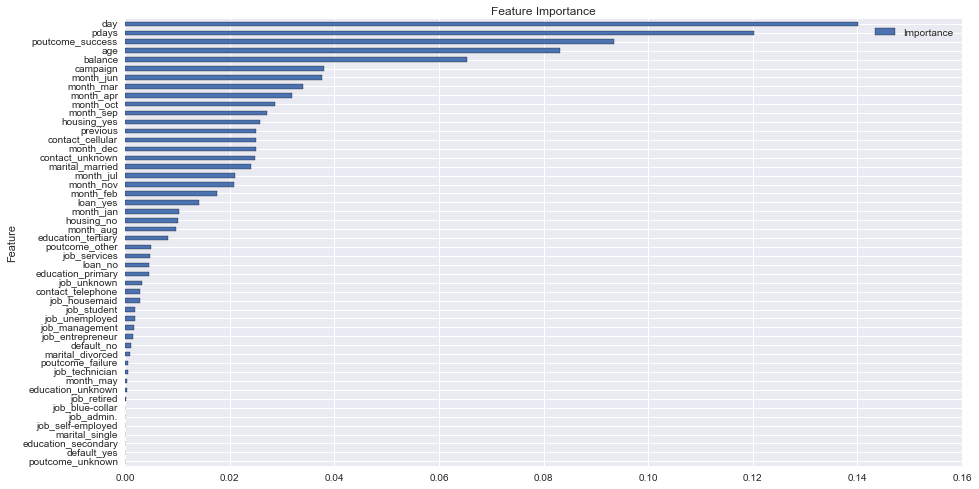

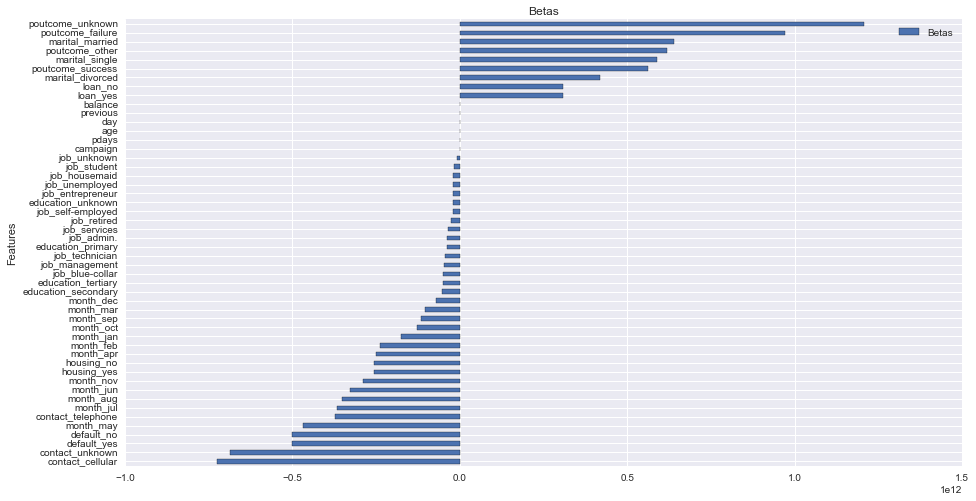

In [115]:
fea.sort_values("Importance").plot(x="Feature",y="Importance",kind="barh",figsize=(15,8),title="Feature Importance")
plt.show()


from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)
beta = reg.coef_
beta_df = pd.DataFrame(beta)
beta_df = beta_df.T
beta_df.columns = ["Betas"]
beta_df["Features"] = data.drop(["y_yes","y_no"],axis=1).columns
beta_df.sort_values("Betas").plot(x="Features",y="Betas",kind="barh",figsize=(15,8),title="Betas")
plt.show()

## Exploring discrepencies between betas and feature importances

Interesting to note that the "day", "age","balance","campaign", and "pdays" columns have some of the highest importances out of any column for determining outcome, but they have close to a zero beta. For futher data exploration, we will plot their distributions.

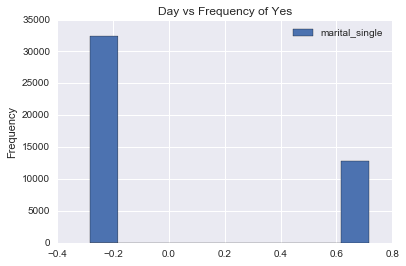

In [93]:
data_norm.plot(y="marital_single",x="y_yes",kind="hist",title="Day vs Frequency of Yes")

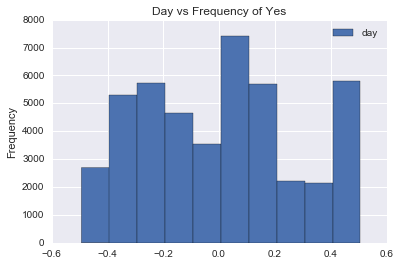

In [91]:
data[["day","y_yes"]].plot(y="day",x="y_yes",kind="hist",title="Day vs Frequency of Yes")

While it seems that there is a high variability between days of the month and the outcome of the model, it is apparent why the beta would be close to zero due to the non-linear distribution.

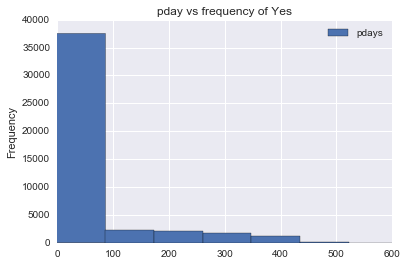

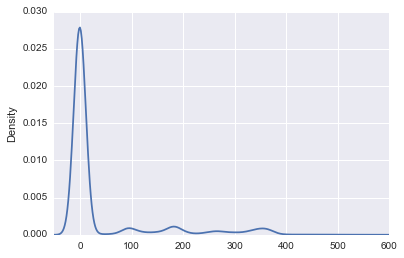

In [47]:
pdays_df = data[["pdays","y_yes"]]
pdays_norm = pdays_df.apply(lambda row: row)
data[["pdays","y_yes"]].plot(y="pdays",x="y_yes",kind="hist",title="pday vs frequency of Yes",xlim=(0,600))
plt.show()
data["pdays"].plot(kind="density",xlim=(-50,600))
plt.show()

pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

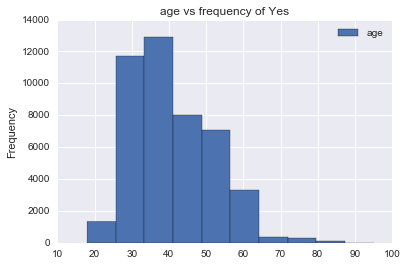

In [33]:
data[["age","y_yes"]].plot(y="age",x="y_yes",kind="hist",title="age vs frequency of Yes")

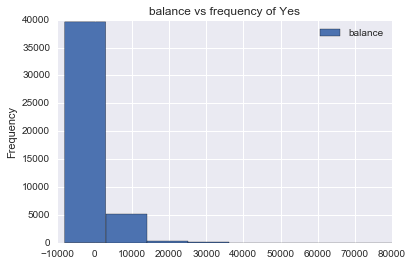

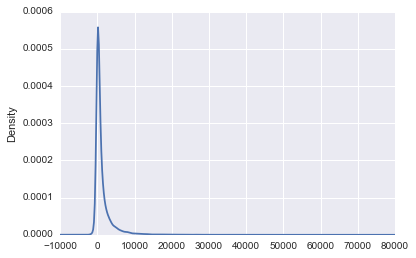

In [76]:
data.plot(y="balance",x="y_yes",kind="hist",title="balance vs frequency of Yes",xlim=(-10000,80000))
plt.show()
data["balance"].plot(kind="density",xlim=(-10000,80000))

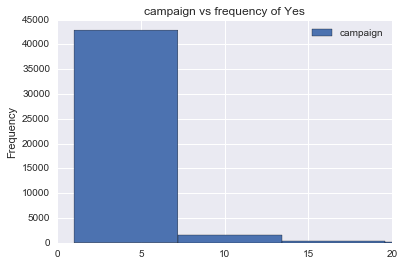

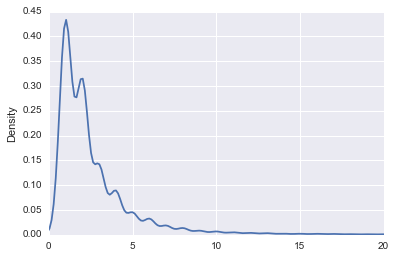

In [41]:
data.plot(y="campaign",x="y_yes",kind="hist",title="campaign vs frequency of Yes",xlim=(0,20))
plt.show()
data["campaign"].plot(kind="density",xlim=(0,20))

# model creation and running models

In [20]:
#just define our variables to use later
NB = GaussianNB()
RFC = RandomForestClassifier()
LD = LDA(solver='lsqr',shrinkage = 'auto')
QD = QDA()
Roc = roc_curve
Roc_score = roc_auc_score

In [21]:
def BayesianClassifier(modeltype, train_X, train_y, test_X, test_y):
    
    '''takes bayesian models of Linear/Quadratic Discriminant Analysis, Gaussian Naiive Bayes
    and returns the predicted probabilities fpr, tpr, threshold, and roc_auc score for the model with your data
    
        Note: data must be in an array   '''
    pos_probs = []

    fitted_model = modeltype.fit(train_X, train_y)
    predicted_y = modeltype.predict(test_X)
    predicted_probabilities = modeltype.predict_proba(test_X)

    for i in predicted_probabilities:
        pos_probs.append(i[1])
    fpr, tpr, threshold = roc_curve(test_y, pos_probs)
    score = roc_auc_score(test_y, pos_probs, average = 'weighted')
    return predicted_probabilities, fpr, tpr, threshold, score


In [22]:
predicted_probabilities, fpr, tpr, threshold, score = BayesianClassifier(NB, X_train, y_train, X_test, y_test)
predicted_probabilities1, fpr1, tpr1, threshold1, score1 = BayesianClassifier(LD, X_train, y_train, X_test, y_test)
predicted_probabilities2, fpr2, tpr2, threshold2, score2 = BayesianClassifier(QD, X_train, y_train, X_test, y_test)
predicted_probabilities3, fpr3, tpr3, threshold3, score3 = BayesianClassifier(RFC, X_train, y_train, X_test, y_test)

C:\Users\Sean\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Sean\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Sean\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Sean\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:688: UserWarning: Variables are colli

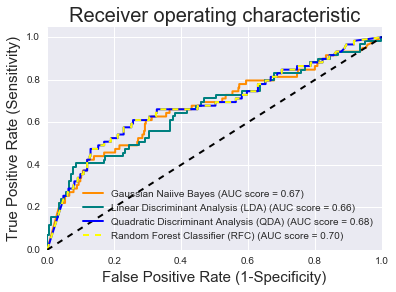

In [23]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Gaussian Naiive Bayes (AUC score = %0.2f)' % score)
plt.plot(fpr1, tpr1, color='teal',
         lw=lw, label='Linear Discriminant Analysis (LDA) (AUC score = %0.2f)' % score1)
plt.plot(fpr2, tpr2, color='blue',
         lw=lw, label='Quadratic Discriminant Analysis (QDA) (AUC score = %0.2f)' % score2)
plt.plot(fpr2, tpr2, color='yellow', linestyle = '--',
         lw=lw, label='Random Forest Classifier (RFC) (AUC score = %0.2f)' % score3)

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)', fontsize=15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)
plt.title('Receiver operating characteristic', fontsize = 20)
plt.legend(loc="best")
plt.show()

# ENSEMBLE MODEL

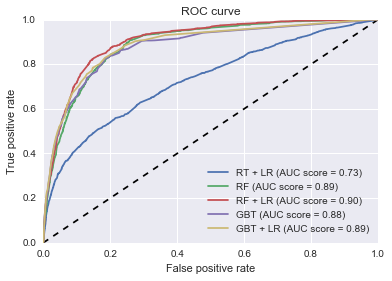

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

n_estimator = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
    random_state=0)

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
score_rt_lm = roc_auc_score(y_test, y_pred_rt, average = 'weighted')

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)
score_rf_lm = roc_auc_score(y_test, y_pred_rf_lm, average = 'weighted')

grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)
score_grd_lm = roc_auc_score(y_test, y_pred_grd_lm, average = 'weighted')



# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
score_grd = roc_auc_score(y_test, y_pred_grd, average = 'weighted')


# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
score_rf = roc_auc_score(y_test, y_pred_rf, average = 'weighted')

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR (AUC score = %0.2f)' % score_rt_lm)
plt.plot(fpr_rf, tpr_rf, label='RF (AUC score = %0.2f)' % score_rf)
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR (AUC score = %0.2f)' % score_rf_lm)
plt.plot(fpr_grd, tpr_grd, label='GBT (AUC score = %0.2f)' % score_grd)
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR (AUC score = %0.2f)' % score_grd_lm)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Predicted   0.0  1.0  __all__
Actual                       
0.0        3591  336     3927
1.0         150   16      166
__all__    3741  352     4093


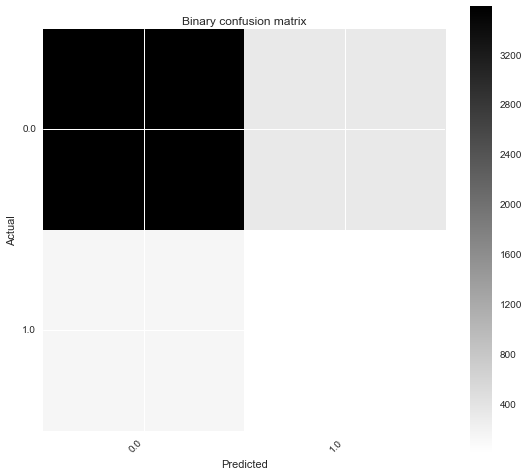

population: 4093
P: 166
N: 3927
PositiveTest: 352
NegativeTest: 3741
TP: 16
TN: 3591
FP: 336
FN: 150
TPR: 0.0963855421687
TNR: 0.914438502674
PPV: 0.0454545454545
NPV: 0.959903769046
FPR: 0.0855614973262
FDR: 0.954545454545
FNR: 0.903614457831
ACC: 0.881260688981
F1_score: 0.0617760617761
MCC: 0.00761568358264
informedness: 0.0108240448425
markedness: 0.00535831450026
prevalence: 0.0405570486196
LRP: 1.1265060241
LRN: 0.988163179032
DOR: 1.14
FOR: 0.0400962309543


In [25]:
from pandas_ml import ConfusionMatrix
def LogReg(modelwparams, X_train, X_test, y_train, y_test):
    
    '''You need to pass this function the LogReg model with the parameters you choose,
    as well as all your data (train/test X's and Y)
    
    make sure your X and y's are arrays'''
    
    LOG = modelwparams
    logit_fit_model = LOG.fit(X_train, y_train)
    pred_y = logit_fit_model.predict(X_test)
    
    cm = ConfusionMatrix(y_test, pred_y)
    print cm
    cm.plot()
    plt.show()
    cm.print_stats()
    
LD = LDA(solver='lsqr',shrinkage = 'auto')
LogReg(LD, X_train, X_test, y_train, y_test)